# Investments Project (Spring 2025)

**Necessary imports**

In [1]:
import os
import wrds
import pandas as pd
import warnings
from datetime import datetime, timedelta
import numpy as np
from functools import reduce
warnings.filterwarnings("ignore")

## 2 - Data Collection

In [2]:
user_name = os.getenv('WRDS_USERNAME')
db = wrds.Connection(wrds_username=user_name)

Loading library list...
Done


In [2]:
# Risk Free Rate 
Rf = db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2002-03-01'
            and mcaldt<='2024-12-31'""", date_cols=['mcaldt'])

Rf['tmytm']=Rf['tmytm'] / 12 / 100 # Convert to monthly rate in decimal


Rf = Rf.rename(columns={ "mcaldt": "date", "tmytm": "rf"})
Rf['date'] = Rf['date'].dt.to_period('M').dt.to_timestamp('M') # Convert every date to the last day of the month 
Rf.set_index('date', inplace = True)

#Get the crsp value-weighted return index
query_crsp = """select  date,vwretd from crsp.msi 
                where date>='2002-03-01' and date<='2024-12-31'"""

crsp_returns = db.raw_sql(query_crsp,  date_cols=['date'])
crsp_returns = crsp_returns.rename(columns={'vwretd': 'us_return'})
crsp_returns.to_csv('data/crsp_return.csv')
Rf.to_csv('data/t_bills_one_month.csv')

NameError: name 'db' is not defined

In [2]:
Rf = pd.read_csv('data/t_bills_one_month.csv')
Rf.set_index('date', inplace = True)
Rf.index = pd.to_datetime(Rf.index)

In [3]:
Rf

,rf
date,
2002-03-31,0.001425
2002-04-30,0.001461
2002-05-31,0.001408
2002-06-30,0.001389
2002-07-31,0.001416
...,...
2024-08-31,0.004380
2024-09-30,0.003826
2024-10-31,0.003752


In [4]:
crsp_returns = pd.read_csv('data/crsp_return.csv')
crsp_returns = crsp_returns.drop(columns= 'Unnamed: 0')
crsp_returns['date'] = pd.to_datetime(crsp_returns['date'])
crsp_returns['date'] = crsp_returns['date'].dt.to_period('M').dt.to_timestamp('M') 

In [5]:
crsp_returns

,date,us_return
0,2002-03-31,0.044698
1,2002-04-30,-0.049600
2,2002-05-31,-0.010510
3,2002-06-30,-0.070259
4,2002-07-31,-0.081125
...,...,...
268,2024-07-31,0.019878
269,2024-08-31,0.021572
270,2024-09-30,0.020969
271,2024-10-31,-0.008298


In [6]:
from dateutil.relativedelta import relativedelta

#Interest Rates: 3-Month or 90-Day Rates and Yields: Interbank Rates
def load_and_prepare_ir3(filepath, rename_dict):
    """
    Load 3-month interbank rates from CSV, convert dates to month-end,
    scale yields from percent to decimal, and set date as index.
    """
    df = pd.read_csv(filepath).rename(columns=rename_dict)
    df['date'] = pd.to_datetime(df['date'])    
    df['date'] = df['date'] - pd.DateOffset(months=1)
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
    df[df.columns[1]] /= 100
    
    return df.set_index('date')                 

# Load each series using the helper
ir3_japan = load_and_prepare_ir3("data/IR3TIB01JPM156N.csv", {"observation_date": "date", "IR3TIB01JPM156N": "ir3_jpn"})
ir3_fra   = load_and_prepare_ir3("data/IR3TIB01FRM156N.csv", {"observation_date": "date", "IR3TIB01FRM156N": "ir3_fra"})
ir3_gb    = load_and_prepare_ir3("data/IR3TIB01GBM156N.csv", {"observation_date": "date", "IR3TIB01GBM156N": "ir3_gb"})
ir3_us    = load_and_prepare_ir3("data/IR3TIB01USM156N.csv", {"observation_date": "date", "IR3TIB01USM156N": "ir3_us"})
ir3_aus   = load_and_prepare_ir3("data/IR3TIB01AUM156N.csv", {"observation_date": "date", "IR3TIB01AUM156N": "ir3_aus"})
ir3_ch    = load_and_prepare_ir3("data/IR3TIB01CHM156N.csv", {"observation_date": "date", "IR3TIB01CHM156N": "ir3_ch"})
ir3_deu   = load_and_prepare_ir3("data/IR3TIB01DEM156N.csv", {"observation_date": "date", "IR3TIB01DEM156N": "ir3_deu"})



# JPY: DEXJPUS (JPY per 1 USD) 
df_jpy = pd.read_csv("data/EXJPUS.csv").rename(columns={"observation_date": "date"})

df_jpy.name = "JPY_per_USD"

# CHF: DEXSZUS (CHF per 1 USD)
df_chf = pd.read_csv("data/EXSZUS.csv").rename(columns={"observation_date": "date"})
df_chf.name = "CHF_per_USD"

# AUD: DEXUSAL (USD per 1 AUD) 
df_aud = pd.read_csv("data/EXUSAL.csv").rename(columns={"observation_date": "date"})
df_aud["AUD_per_USD"] = 1 / df_aud["EXUSAL"]


# EUR: DEXUSEU (USD per 1 EUR) 
df_eur = pd.read_csv("data/EXUSEU.csv").rename(columns={"observation_date": "date"})
df_eur["EUR_per_USD"] = 1 / df_eur["EXUSEU"]

# GBP: DEXUSUK (USD per 1 GBP) 
df_gbp = pd.read_csv("data/EXUSUK.csv").rename(columns={"observation_date": "date"})
df_gbp["GBP_per_USD"] = 1 / df_gbp["EXUSUK"]

files = {
    'jpn': 'data/jpn.csv',
    'aus': 'data/aus.csv',
    'deu': 'data/deu.csv',
    'fra': 'data/fra.csv',
    'ch':  'data/swz.csv',
    'gb':  'data/uk.csv'
}

countries_returns_dict = {}

for code, path in files.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
 
    return_col = [col for col in df.columns if col != 'date'][0]
    df = df.rename(columns={return_col: f'{code}_return'})
    countries_returns_dict[code] = df

In [7]:
countries_returns_dict

{'jpn':     jpn_return       date country currency  mportret  mportretx
 0          JPN 2002-03-31   JAPAN      JPY  0.053119   0.048294
 1          JPN 2002-04-30   JAPAN      JPY  0.020586   0.020574
 2          JPN 2002-05-31   JAPAN      JPY  0.035987   0.035920
 3          JPN 2002-06-30   JAPAN      JPY -0.083764  -0.083961
 4          JPN 2002-07-31   JAPAN      JPY -0.057720  -0.057960
 ..         ...        ...     ...      ...       ...        ...
 268        JPN 2024-07-31   JAPAN      JPY -0.004150  -0.004275
 269        JPN 2024-08-31   JAPAN      JPY -0.024404  -0.024809
 270        JPN 2024-09-30   JAPAN      JPY -0.014245  -0.023069
 271        JPN 2024-10-31   JAPAN      JPY  0.016975   0.016898
 272        JPN 2024-11-30   JAPAN      JPY -0.007304  -0.007408
 
 [273 rows x 6 columns],
 'aus':     aus_return       date    country currency  mportret  mportretx
 0          AUS 2002-03-31  AUSTRALIA      AUD  0.005199  -0.001914
 1          AUS 2002-04-30  AUSTRALIA      

In [8]:
foreign_to_usd = pd.concat([
    df_jpy['EXJPUS'].rename("JPY_per_USD"),
    df_chf['EXSZUS'].rename("CHF_per_USD"),
    df_aud['AUD_per_USD'].rename("AUD_per_USD"),
    df_eur['EUR_per_USD'].rename("EUR_per_USD"),
    df_gbp['GBP_per_USD'].rename("GBP_per_USD")
], axis=1)


index = pd.to_datetime(df_jpy['date'])- pd.DateOffset(months=1)
foreign_to_usd.index =  index.dt.to_period('M').dt.to_timestamp('M') 

In [9]:
foreign_to_usd

,JPY_per_USD,CHF_per_USD,AUD_per_USD,EUR_per_USD,GBP_per_USD
date,,,,,
2002-03-31,130.7718,1.6542,1.868460,1.128668,0.693049
2002-04-30,126.3750,1.5889,1.818843,1.090513,0.685025
2002-05-31,123.2905,1.5399,1.759944,1.045916,0.673991
2002-06-30,117.8991,1.4718,1.805706,1.006543,0.642467
2002-07-31,118.9927,1.4972,1.847404,1.022390,0.650703
...,...,...,...,...,...
2024-07-31,146.2641,0.8579,1.501953,0.907441,0.772499
2024-08-31,142.9540,0.8472,1.477105,0.900576,0.756487
2024-09-30,149.8909,0.8613,1.492537,0.917852,0.766695


**Visualizing the data**

<Figure size 800x400 with 0 Axes>

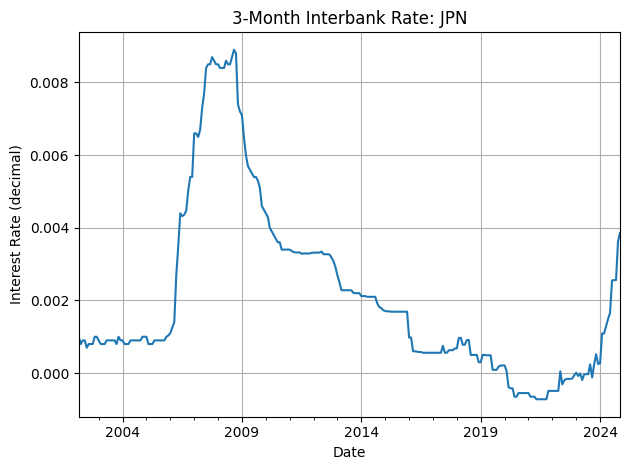

<Figure size 800x400 with 0 Axes>

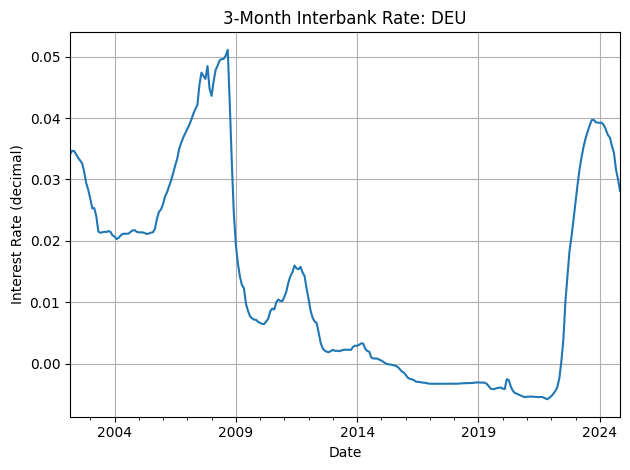

<Figure size 800x400 with 0 Axes>

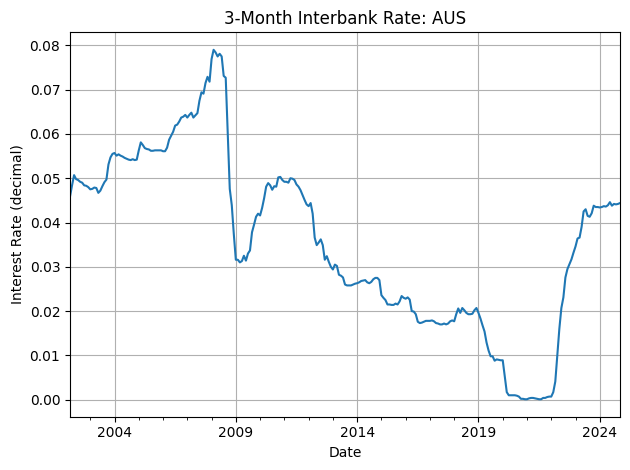

<Figure size 800x400 with 0 Axes>

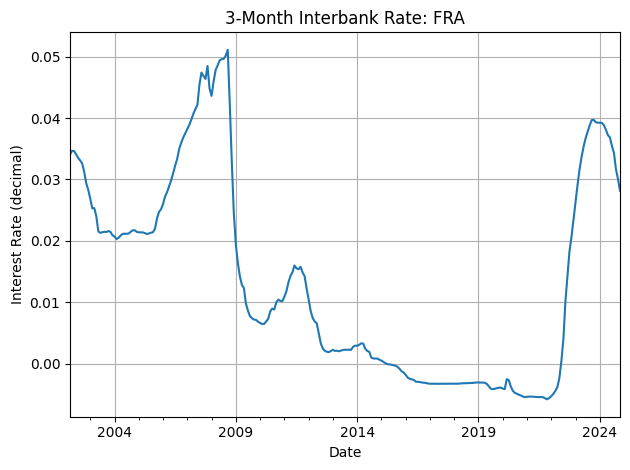

<Figure size 800x400 with 0 Axes>

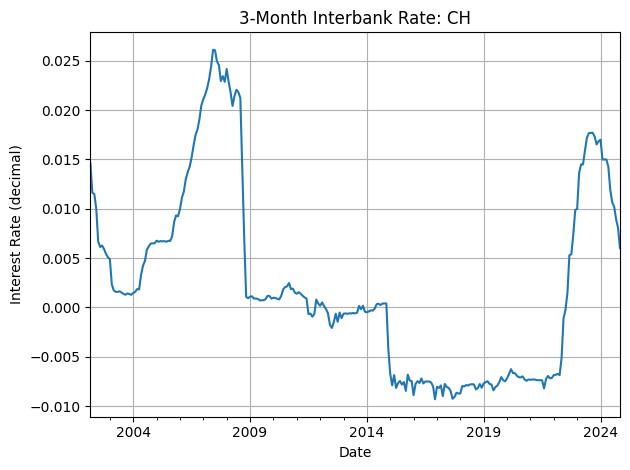

<Figure size 800x400 with 0 Axes>

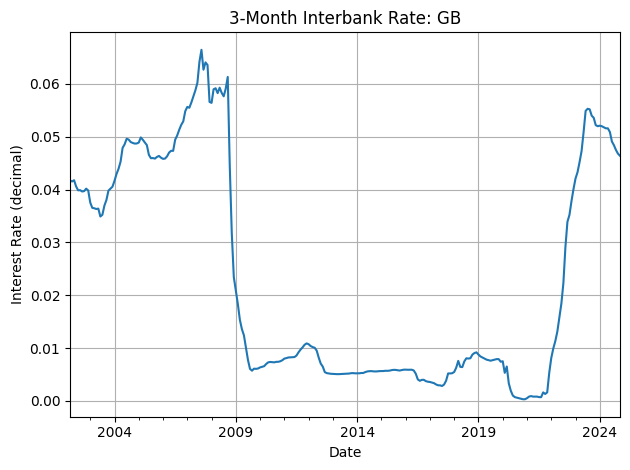

<Figure size 800x400 with 0 Axes>

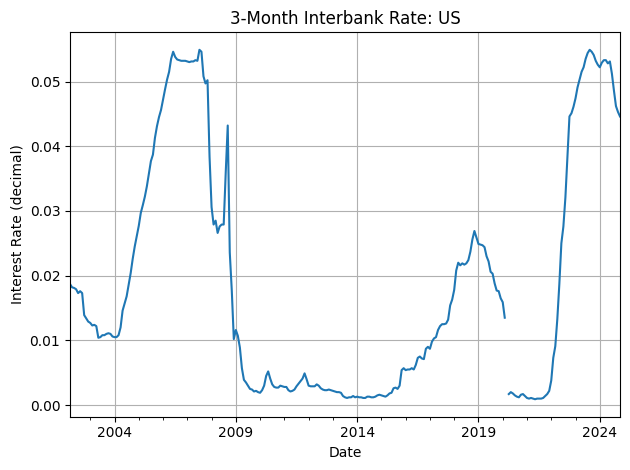

In [10]:
import matplotlib.pyplot as plt

ir3_data = {
    'jpn': ir3_japan,
    'deu': ir3_deu,
    'aus': ir3_aus,
    'fra': ir3_fra,
    'ch': ir3_ch,
    'gb': ir3_gb,
    'us' : ir3_us
}

for country, df in ir3_data.items():
    plt.figure(figsize=(8, 4))
    df.plot(y=f'ir3_{country}', legend=False)
    plt.title(f'3-Month Interbank Rate: {country.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (decimal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We observe a missing value in 2020 for the us interbank rate, to replace it we will use interpolation.

In [11]:
ir3_data['us'] = ir3_us.interpolate(method='time')

<Axes: xlabel='date'>

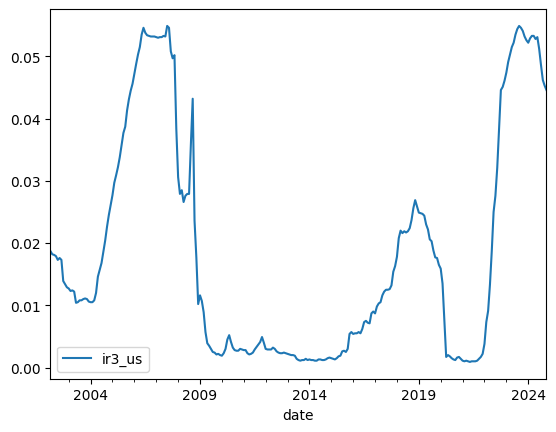

In [12]:
ir3_data['us'].plot()

Now it is interpolated, and all our data is continuous !

In [13]:
#Merge all the interbank together

df_ir3_all_countries = pd.concat(
    [df.rename(columns={df.columns[0]: f'ir3_{code}'}) for code, df in ir3_data.items()],
    axis=1,
    join='outer'
)
df_ir3_all_countries = df_ir3_all_countries.dropna()

In [14]:
df_ir3_all_countries

,ir3_jpn,ir3_deu,ir3_aus,ir3_fra,ir3_ch,ir3_gb,ir3_us
date,,,,,,,
2002-03-31,0.00100,0.034069,0.0459,0.034069,0.014606,0.041732,0.0187
2002-04-30,0.00080,0.034671,0.0484,0.034671,0.011635,0.041537,0.0182
2002-05-31,0.00090,0.034640,0.0507,0.034640,0.011496,0.041776,0.0181
2002-06-30,0.00090,0.034100,0.0498,0.034100,0.010031,0.040605,0.0179
2002-07-31,0.00070,0.033519,0.0496,0.033519,0.006683,0.039865,0.0173
...,...,...,...,...,...,...,...
2024-07-31,0.00255,0.035476,0.0438,0.035476,0.010665,0.049100,0.0512
2024-08-31,0.00256,0.034337,0.0442,0.034337,0.010221,0.048400,0.0486
2024-09-30,0.00256,0.031666,0.0441,0.031666,0.008945,0.047500,0.0462


**Let's plot the exchange rate**

<Figure size 1000x400 with 0 Axes>

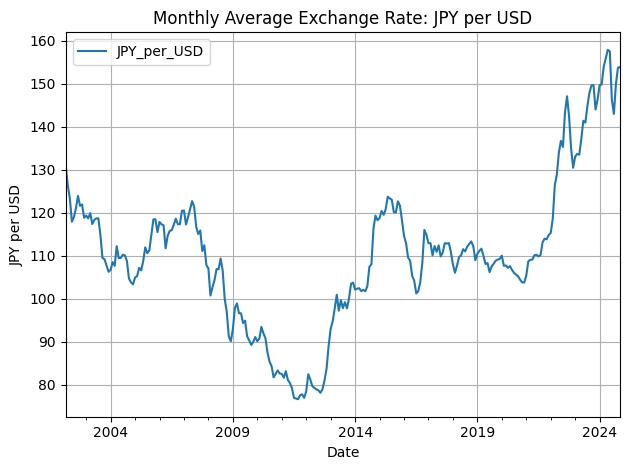

<Figure size 1200x600 with 0 Axes>

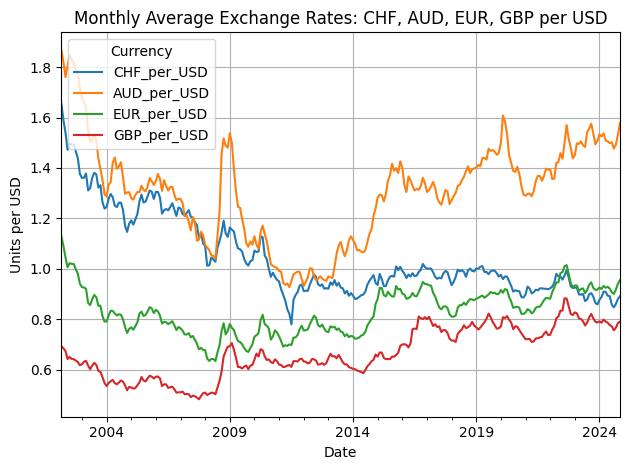

In [15]:
# Separate JPY from others

monthly_jpy = foreign_to_usd[['JPY_per_USD']]
monthly_others = foreign_to_usd.drop(columns='JPY_per_USD')


plt.figure(figsize=(10, 4))
monthly_jpy.plot()
plt.title("Monthly Average Exchange Rate: JPY per USD")
plt.xlabel("Date")
plt.ylabel("JPY per USD")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
monthly_others.plot()
plt.title("Monthly Average Exchange Rates: CHF, AUD, EUR, GBP per USD")
plt.xlabel("Date")
plt.ylabel("Units per USD")
plt.grid(True)
plt.legend(title="Currency", loc="upper left")
plt.tight_layout()
plt.show()

## 3 - The International Diversification Strategy (DIV)

### 3.a - Unhedged Dollar Return from Foreign Investment

Let:

- $X_t$ be the **exchange rate** at time $t$, expressed in **USD per unit of foreign currency** (e.g., USD per EUR).
- $P_t$ be the **foreign currency price** of the foreign stock market (including dividends), denominated in **foreign currency**.

Then the **unhedged dollar return** $R_{\text{noh}}$ of \$1 invested in the foreign stock market is:

$$
R_{\text{noh}} = \frac{P_{t+1} \cdot X_{t+1}}{P_t \cdot X_t} - 1
$$

### Units

| Symbol     | Description                                | Units                     |
|------------|--------------------------------------------|---------------------------|
| $X_t$   | Exchange rate (USD per 1 foreign currency) | $\frac{USD}{FX}$                    |
| $P_t$   | Foreign stock index (cum dividends)        | FX (foreign currency)     |
| $P_t X_t$ | Dollar value of the investment            | USD                       |


In [16]:
usd_to_foreign = 1 / foreign_to_usd
usd_to_foreign.columns = [f'USD_PER_{col.split("_")[0]}' for col in usd_to_foreign.columns]

In [17]:
def convert_foreign_to_usd(ret_foreign_currency, ret_fx):
    """
    Convert a return earned in foreign currency into the equivalent USD return.

    Parameters
    ----------
    ret_foreign_currency : float
        Period return of the asset in its local currency (e.g. 0.10 for +10%).
    ret_fx : float
        Period return of the foreign currency vs. USD (e.g. -0.05 if it weakened 5%).

    Returns
    -------
    float
        Total USD return over the period.
    
    Formula
    -------
    USD_return = (1 + local_return) * (1 + fx_return) - 1
    """
    return (1 + ret_foreign_currency) * (1 + ret_fx) - 1


# Step 1: Compute FX returns
ret_exchange_rate = usd_to_foreign/ usd_to_foreign.shift(1) - 1 # shift by one to get period-over-period returns
ret_exchange_rate.dropna(inplace=True)
ret_exchange_rate.sort_index(inplace=True)


def process_country(df, fx_column, ret_exchange_rate):
    """
    Align and convert a country's local-market returns into USD.

    Steps:
      1. Select only the date, country, and mportret (local-market return) columns.
      2. Drop any rows where the local return is missing.
      3. Merge with the fx-returns series on date (inner join) to align observations.
      4. Use `convert_foreign_to_usd` to turn the local return + fx return into a USD return.
      5. Return a DataFrame of date, country, and the converted mportret (in USD).

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['date', 'country', 'mportret'] where 'mportret' is
        the local-currency return.
    fx_column : str
        Name of the column in `ret_exchange_rate` that holds the currency's
        return vs. USD.
    ret_exchange_rate : pd.DataFrame
        Indexed by date, with at least the fx_column of period-over-period
        currency returns (decimal form).

    Returns
    -------
    pd.DataFrame
        Columns ['date', 'country', 'mportret'], where 'mportret' is now the
        total USD return.
    """
    df = df[['date', 'country', 'mportret']].copy()
    df.dropna(subset=['mportret'], inplace=True)

    # Merge on date to align
    df = df.merge(ret_exchange_rate[[fx_column]], how='inner', left_on='date', right_index=True)

    # Convert to USD returns
    df['mportret'] = convert_foreign_to_usd(df['mportret'], df[fx_column])
    df = df[['date', 'country', 'mportret']]
    return df


jpn = process_country(countries_returns_dict['jpn'], 'USD_PER_JPY', ret_exchange_rate)
aus = process_country(countries_returns_dict['aus'], 'USD_PER_AUD', ret_exchange_rate)
deu = process_country(countries_returns_dict['deu'], 'USD_PER_EUR', ret_exchange_rate)
fra = process_country(countries_returns_dict['fra'], 'USD_PER_EUR', ret_exchange_rate)
ch  = process_country(countries_returns_dict['ch'],  'USD_PER_CHF', ret_exchange_rate)
gb  = process_country(countries_returns_dict['gb'],  'USD_PER_GBP', ret_exchange_rate)


crsp_returns['country'] = 'US'
crsp_returns.rename(columns={'us_return': 'mportret'}, inplace=True)
us = crsp_returns[['date', 'country', 'mportret']].copy()

commond_date = us.index.intersection(fra.index)
us = us.loc[commond_date]


# Combine all
df_countries_usd_ret = pd.concat([jpn, aus, deu, fra, ch, gb, us], axis=0, ignore_index=True)


In [18]:
df_countries_usd_ret['date'] = pd.to_datetime(df_countries_usd_ret['date'])
df_countries_usd_ret['date'] = df_countries_usd_ret['date'].dt.to_period('M').dt.to_timestamp('M')

In [19]:
df_countries_usd_ret

,date,country,mportret
0,2002-04-30,JAPAN,0.056094
1,2002-05-31,JAPAN,0.061906
2,2002-06-30,JAPAN,-0.041866
3,2002-07-31,JAPAN,-0.066380
4,2002-08-31,JAPAN,-0.041213
...,...,...,...
1899,2024-07-31,US,0.019878
1900,2024-08-31,US,0.021572
1901,2024-09-30,US,0.020969
1902,2024-10-31,US,-0.008298


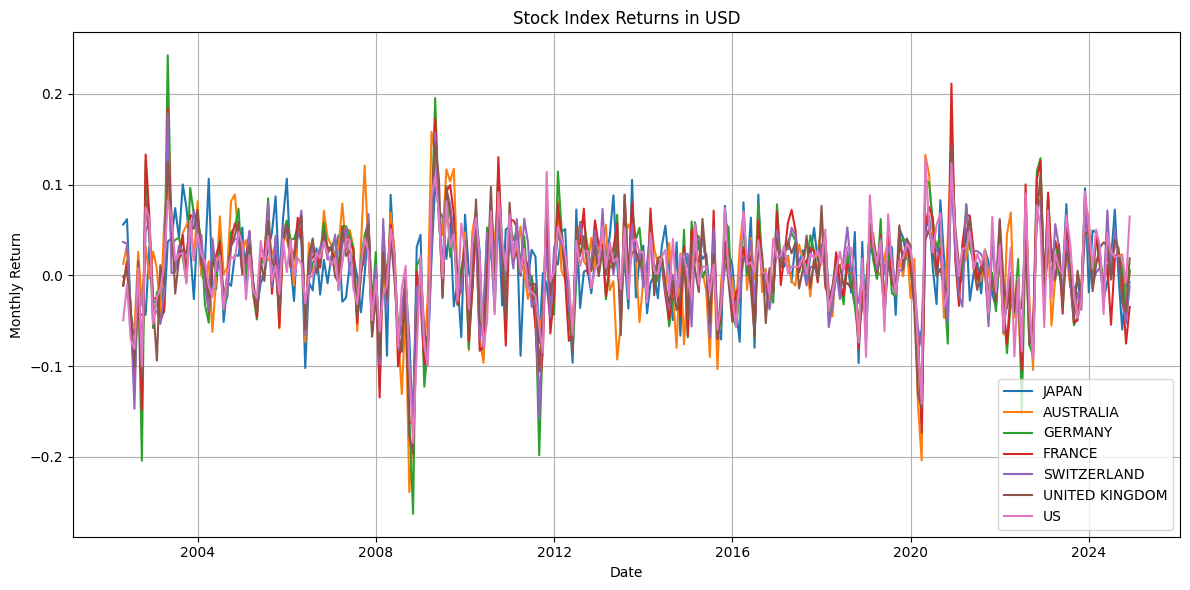

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for country in df_countries_usd_ret['country'].unique():
    subset = df_countries_usd_ret[df_countries_usd_ret['country'] == country]
    plt.plot(subset['date'], subset['mportret'], label=country)

plt.title('Stock Index Returns in USD')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
df_countries_usd_ret_pivoted = df_countries_usd_ret.pivot(index='date', columns='country', values='mportret')

In [22]:
df_countries_usd_ret_pivoted

country,AUSTRALIA,FRANCE,GERMANY,JAPAN,SWITZERLAND,UNITED KINGDOM,US
date,,,,,,,
2002-04-30,0.012587,-0.010538,-0.011617,0.056094,0.036820,-0.001806,-0.049600
2002-05-31,0.033256,0.013428,0.015840,0.061906,0.034877,0.004702,-0.010510
2002-06-30,-0.051421,-0.044850,-0.032251,-0.041866,-0.039197,-0.037508,-0.070259
2002-07-31,-0.059533,-0.117957,-0.122706,-0.066380,-0.147091,-0.101053,-0.081125
2002-08-31,0.025970,-0.002077,-0.000348,-0.041213,0.007842,0.015599,0.007949
...,...,...,...,...,...,...,...
2024-07-31,0.035730,0.018647,0.019748,0.072474,0.050481,0.039456,0.019878
2024-08-31,0.021983,0.025529,0.025336,-0.001815,0.017400,0.029770,0.021572
2024-09-30,0.022941,-0.010247,0.007013,-0.059865,-0.027682,-0.030240,0.020969


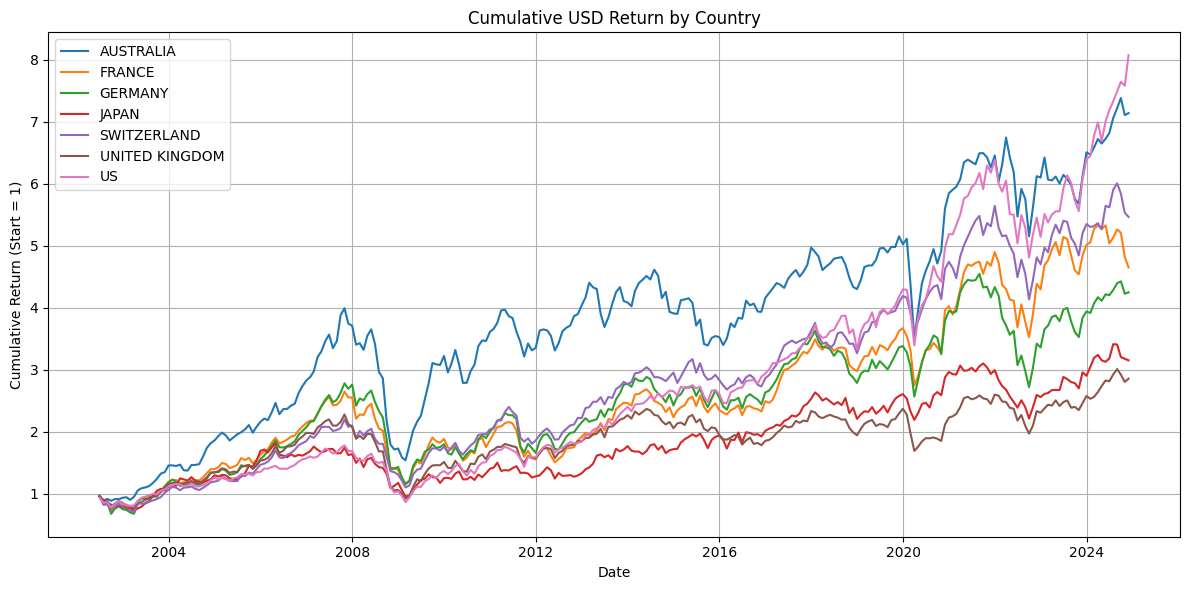

In [23]:
countries_filtered = df_countries_usd_ret[df_countries_usd_ret['date'] > '2002-05-31']

plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country, group in countries_filtered.groupby('country'):
    cumulative = (1 + group['mportret']).cumprod()
    plt.plot(group['date'], cumulative, label=country)

plt.title('Cumulative USD Return by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.b - Currency-Hedged Excess Return in USD

The formula for the **excess return** in USD from a $1 investment in the Euro-currency hedged via shorting the foreign currency is:

$$
X_{t+1}^{\text{EU}} = \frac{S_{t+1}}{S_t}(1 + r^{\text{EU}}) - (1 + r^{\text{US}})
$$

Where:

- $X_{t+1}^{\text{EU}}$: Excess return in USD from the currency-hedged investment in the Euro-currency  
- $S_t$: Spot exchange rate at time $t$, in USD per EUR  
- $S_{t+1}$: Spot exchange rate at time $t+1$, in USD per EUR  
- $r^{\text{EU}}$: Risk-free interest rate in the Eurozone over the period  
- $r^{\text{US}}$: Risk-free interest rate in the US over the period  


First, let's get USD per EUR.

In [24]:
proportion = usd_to_foreign / usd_to_foreign.shift(1)
proportion = proportion.dropna()



ir3_filtered_shifted = df_ir3_all_countries.shift(1)
ir3_filtered_shifted.dropna(inplace=True)

excess_return = pd.DataFrame({
    'JAPAN': proportion['USD_PER_JPY'] * (1 + ir3_filtered_shifted['ir3_jpn']) - (1 + ir3_filtered_shifted['ir3_us']  ),
    'FRANCE': proportion['USD_PER_EUR'] * (1 + ir3_filtered_shifted['ir3_fra']) - (1 + ir3_filtered_shifted['ir3_us']  ),
    'GERMANY': proportion['USD_PER_EUR'] * (1 + ir3_filtered_shifted['ir3_deu']) - (1 + ir3_filtered_shifted['ir3_us'] ),
    'AUSTRALIA': proportion['USD_PER_AUD'] * (1 + ir3_filtered_shifted['ir3_aus']) - (1 + ir3_filtered_shifted['ir3_us'] ),
    'SWITZERLAND': proportion['USD_PER_CHF'] * (1 + ir3_filtered_shifted['ir3_ch']) - (1 + ir3_filtered_shifted['ir3_us']),
    'UNITED KINGDOM': proportion['USD_PER_GBP'] * (1 + ir3_filtered_shifted['ir3_gb']) - (1 + ir3_filtered_shifted['ir3_us'] )
})

hedge_return = pd.DataFrame()
df_countries_usd_returns = ['JAPAN', 'FRANCE', 'GERMANY', 'AUSTRALIA', 'SWITZERLAND', 'UNITED KINGDOM']

for c in df_countries_usd_returns:
    df = df_countries_usd_ret[df_countries_usd_ret['country'] == c].copy()
    df = df.set_index('date')  


    excess = excess_return[c]
    common_date = excess.index.intersection(df.index)

    df = df.loc[common_date]
    excess = excess.loc[common_date]

    # Align both on index intersection
    aligned_df, aligned_excess = df.align(excess, join='inner', axis=0)

    hedge_return[c] = aligned_df['mportret'] - aligned_excess


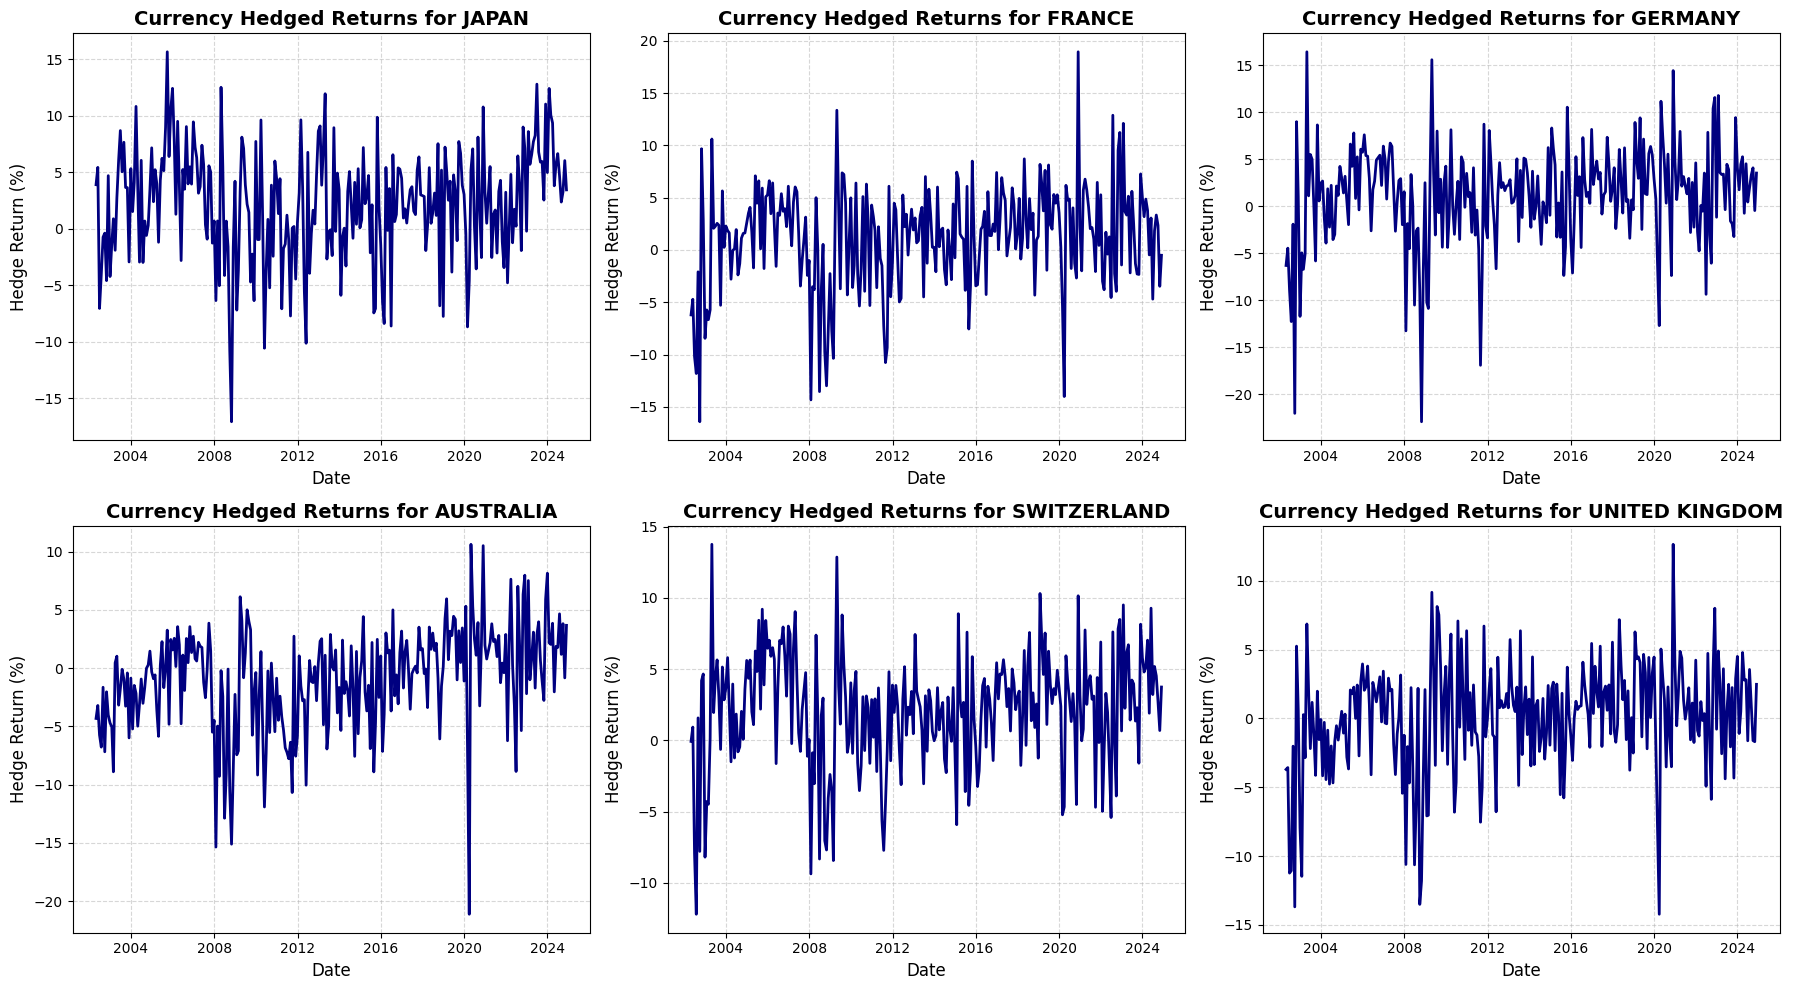

In [25]:
import matplotlib.pyplot as plt


df_countries_usd_returns = hedge_return.columns[:6] 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()  

for i, country in enumerate(df_countries_usd_returns):
    ax = axes[i]
    ax.plot(hedge_return[country] * 100, color='navy', linewidth=2)
    ax.set_title(f'Currency Hedged Returns for {country.upper()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Hedge Return (%)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)


for j in range(len(df_countries_usd_returns), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [26]:
us  = df_countries_usd_ret[df_countries_usd_ret['country']  == 'US'].set_index('date').drop(columns='country', axis=1)
us.rename({'mportret' : 'US'}, axis = 1, inplace=True)
common = us.index.intersection(hedge_return.index)

us = us.loc[common]


hedge_return = hedge_return.merge(us, on='date')

In [27]:
hedge_return

,JAPAN,FRANCE,GERMANY,AUSTRALIA,SWITZERLAND,UNITED KINGDOM,US
date,,,,,,,
2002-04-30,0.038967,-0.062088,-0.063167,-0.043144,-0.000784,-0.037039,-0.049600
2002-05-31,0.054268,-0.047160,-0.044748,-0.032030,0.009252,-0.035688,-0.010510
2002-06-30,-0.070436,-0.101862,-0.089264,-0.057393,-0.079394,-0.112300,-0.070259
2002-07-31,-0.040181,-0.118127,-0.122877,-0.067738,-0.122086,-0.110588,-0.081125
2002-08-31,-0.007378,-0.020937,-0.019208,-0.016413,0.015695,-0.020161,0.007949
...,...,...,...,...,...,...,...
2024-07-31,0.046843,0.018362,0.019463,0.046578,0.051778,0.035531,0.019878
2024-08-31,0.023621,0.033360,0.033167,0.011824,0.045171,0.009664,0.021572
2024-09-30,0.032573,0.023484,0.040744,0.038138,0.027234,-0.016082,0.020969


In [28]:
hedge_return.to_csv('data/q3/hedge_return.csv')

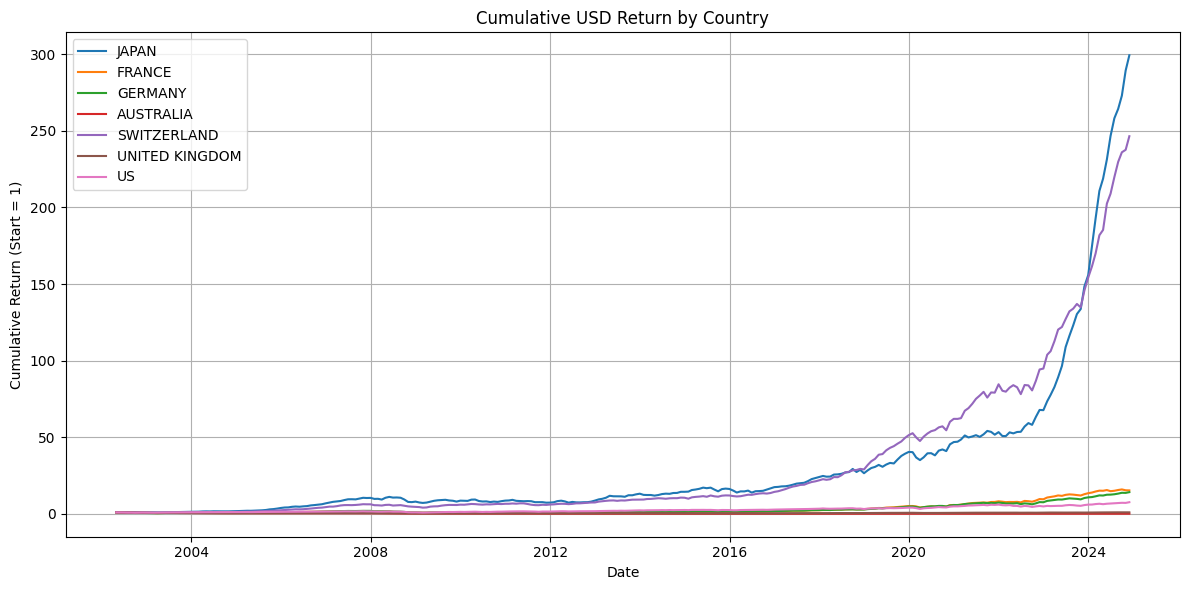

In [29]:
plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country in hedge_return.columns:
    cumulative = (1 + hedge_return[country]).cumprod()
    plt.plot(hedge_return.index, cumulative, label=country)

plt.title('Cumulative USD Return by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.c

### Equal weight the indexes No currency hedging

In [30]:
def evaluate_strategy_performance(strategy_return: pd.Series, Rf: pd.Series, name: str = "Strategy", zero_cost = False):
    """
    Evaluate the performance of a strategy vs. the risk-free rate and prints the performance summary including mean excess return, 
     annualized standard deviation, and Sharpe ratio.

    Parameters
    ----------
    strategy_return : pd.Series
        Strategy's monthly returns indexed by date.
    Rf : pd.Series
        Risk-free rate series indexed by date (same frequency/units).
    name : str, optional
        Label used in the printed report (default “Strategy”).
    zero_cost : bool, default False
        If True, treat the strategy as zero-cost (don't subtract Rf when computing mean excess).

    Prints
    ------
    - Annualized mean excess return
    - Annualized standard deviation
    - Annualized Sharpe ratio
    """
    strategy_return = strategy_return.dropna()

    # Align both series
    common_dates = strategy_return.index.intersection(Rf.index)

    aligned_strategy = strategy_return.loc[common_dates]
    aligned_rf = Rf.loc[common_dates]
    
    # Compute excess returns
    if zero_cost : 
         mean_excess = aligned_strategy.mean() 
    else : 
         mean_excess = aligned_strategy.mean() - aligned_rf['rf'].mean()

   
    std_excess = aligned_strategy.std()
    sharpe_annualized = (mean_excess / std_excess) * np.sqrt(12)

    print("-" * 50)
    print(f"Performance Summary for: {name}")
    print(f"Mean Annual Excess Return : {mean_excess*12:.5f}")
    print(f"Annual Standard Deviation : {(std_excess*np.sqrt(12)):.5f}")
    print(f"Annualized Sharpe Ratio   : {sharpe_annualized:.3f}")
    print("-" * 50)

In [31]:
equal_weight = df_countries_usd_ret_pivoted.mean(axis=1)
evaluate_strategy_performance(equal_weight, Rf, name="Equal Weight Strategy")

--------------------------------------------------
Performance Summary for: Equal Weight Strategy
Mean Annual Excess Return : 0.07048
Annual Standard Deviation : 0.15243
Annualized Sharpe Ratio   : 0.462
--------------------------------------------------


### Equal weight the indexes currency hedging

In [32]:
equal_weight_hedged = hedge_return.mean(axis=1)
evaluate_strategy_performance(equal_weight_hedged, Rf,name = "Equal Weight Hedged Return Strategy")

--------------------------------------------------
Performance Summary for: Equal Weight Hedged Return Strategy
Mean Annual Excess Return : 0.09830
Annual Standard Deviation : 0.13911
Annualized Sharpe Ratio   : 0.707
--------------------------------------------------


### Risk-Parity based on a 60 months rolling window estimate of the strategy returns volatilities

In [33]:
windowed_std = df_countries_usd_ret_pivoted.rolling(window=60).std()
windowed_std.dropna(inplace=True)

rp_weights = 1 / windowed_std

# We shift because we invest based on the avaialble information at time t not time t+1
rp_weights_normalized = rp_weights.div(rp_weights.sum(axis=1), axis=0).shift(1).dropna()


common_dates = df_countries_usd_ret_pivoted.index.intersection(rp_weights_normalized.index)
aligned_extend_pivoted = df_countries_usd_ret_pivoted.loc[common_dates]


value_portfolio = aligned_extend_pivoted * rp_weights_normalized

In [34]:
portfolio_returns = value_portfolio.sum(axis=1)

evaluate_strategy_performance(portfolio_returns, Rf,name='Risk parity strategy')

--------------------------------------------------
Performance Summary for: Risk parity strategy
Mean Annual Excess Return : 0.04940
Annual Standard Deviation : 0.15479
Annualized Sharpe Ratio   : 0.319
--------------------------------------------------


### Risk-Parity based on a 60 months rolling window estimate of the strategy returns volatilities with currency hedge

In [35]:
windowed_std_hedge = hedge_return.rolling(window=60).std()
windowed_std_hedge.dropna(inplace=True)

rp_weights_hedge = 1 / windowed_std_hedge
rp_weights_hedge_normalized = rp_weights_hedge.div(rp_weights_hedge.sum(axis=1), axis=0).shift(1).dropna()

common_dates_hedge = hedge_return.index.intersection(rp_weights_hedge_normalized.index)
aligned_extended_pivoted_hedge = hedge_return.loc[common_dates_hedge]

value_portfolio_hedge = aligned_extended_pivoted_hedge * rp_weights_hedge_normalized

In [36]:
div = value_portfolio_hedge .sum(axis=1)

evaluate_strategy_performance(div,  Rf,name='Risk parity strategy with currency hedge')

--------------------------------------------------
Performance Summary for: Risk parity strategy with currency hedge
Mean Annual Excess Return : 0.09712
Annual Standard Deviation : 0.13981
Annualized Sharpe Ratio   : 0.695
--------------------------------------------------


### Mean-variance optimal combination based on the rolling window mean and co-variance matrix

In [37]:
def compute_mve(cov_windowed, mean_windowed, df) :
    """
    Generate the time series of realized returns for a monthly tangency (maximum-Sharpe) portfolio.

    Parameters
    ----------
    cov_windowed : pd.DataFrame
        Multi-indexed (date x asset x asset) or a Panel-like object of rolling covariance matrices.
    mean_windowed : pd.DataFrame
        Indexed by date with each row giving expected returns for each asset.
    df : pd.DataFrame
        Realized returns (date x asset) to which the computed weights will be applied.

    Returns
    -------
    pd.Series
        The portfolio's realized return on each date using weights w = Σ⁻¹(μ - r_f).
    """
    tangency_weights = {}
    risk_aversion = 1

    for date in mean_windowed.index:

        cov = cov_windowed.loc[date].to_numpy()
        mean = mean_windowed.loc[date]
        rf = Rf.loc[date].to_numpy()

        mu_excess = mean - rf  

        weights = np.linalg.inv(cov)@(mu_excess)

        tangency_weights[date] = pd.Series(weights /risk_aversion, index=mean.index)

        
    tangency_weights_df = pd.DataFrame(tangency_weights).T
    tangency_weights_df.index.name = 'date'
    tangency_weights_df.columns.name = 'country'

    common_dates = df.index.intersection(tangency_weights_df.index)
    aligned_extend_pivoted = df.loc[common_dates]



    value_portfolio = aligned_extend_pivoted *tangency_weights_df
    tangency_return = value_portfolio.sum(axis=1)


    return tangency_return

In [38]:
mean_windowed = df_countries_usd_ret_pivoted.rolling(window=60).mean()
cov_windowed  = df_countries_usd_ret_pivoted.rolling(window=60).cov()

mean_windowed.dropna(inplace=True)
cov_windowed.dropna(inplace=True)


tangency_return =  compute_mve(cov_windowed, mean_windowed, df_countries_usd_ret_pivoted)

evaluate_strategy_performance(tangency_return , Rf,name='Tangency portfolio without currency hedge')

--------------------------------------------------
Performance Summary for: Tangency portfolio without currency hedge
Mean Annual Excess Return : 2.46941
Annual Standard Deviation : 1.68095
Annualized Sharpe Ratio   : 1.469
--------------------------------------------------


<Axes: title={'center': 'MVE portfolio with a risk aversion of 1'}, xlabel='date'>

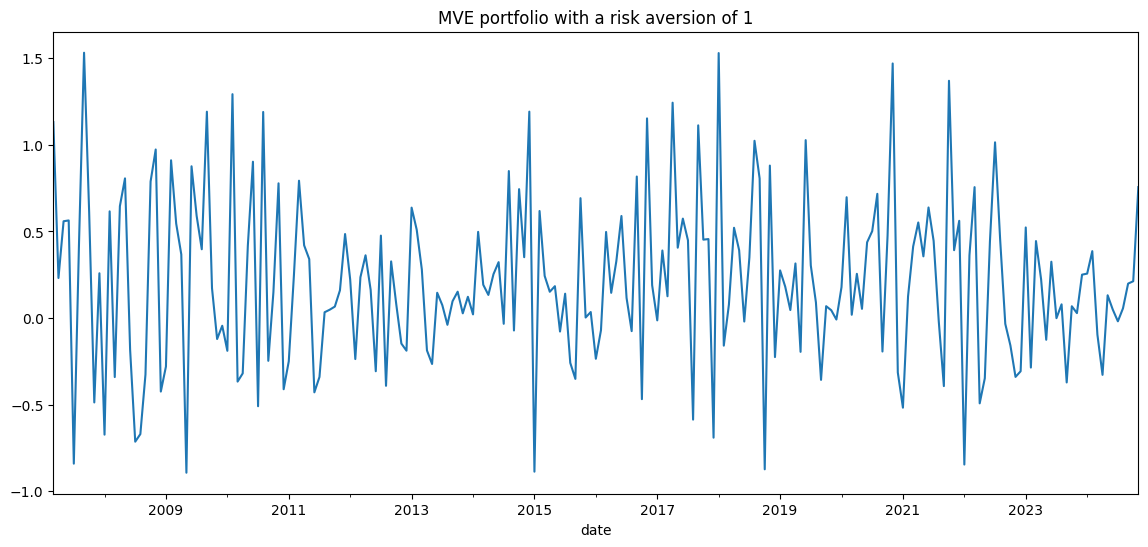

In [39]:
tangency_return.plot(title='MVE portfolio with a risk aversion of 1', figsize=(14, 6))

In [40]:
mean_windowed = hedge_return.rolling(window=60).mean()
cov_windowed = hedge_return.rolling(window=60).cov()

mean_windowed.dropna(inplace=True)
cov_windowed.dropna(inplace=True)

tangency_return_hedged =  compute_mve(cov_windowed, mean_windowed, hedge_return)


evaluate_strategy_performance(tangency_return_hedged, Rf, name='Tangency currency hedged strategy')

--------------------------------------------------
Performance Summary for: Tangency currency hedged strategy
Mean Annual Excess Return : 24.63262
Annual Standard Deviation : 6.44604
Annualized Sharpe Ratio   : 3.821
--------------------------------------------------


<Axes: title={'center': 'MVE portfolio hedged with a risk aversion of 1'}, xlabel='date'>

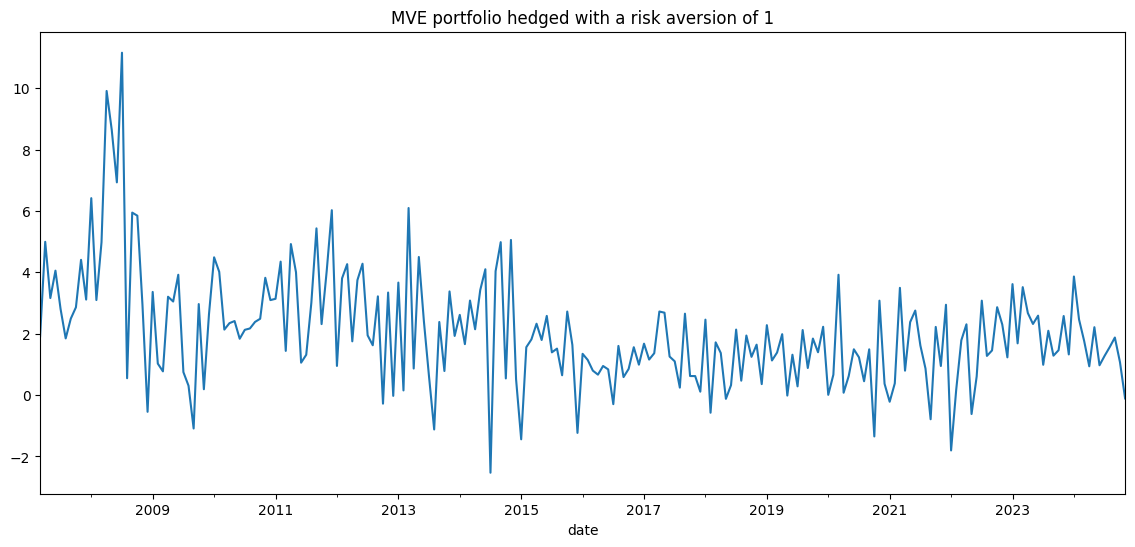

In [41]:
tangency_return_hedged.plot(title='MVE portfolio hedged with a risk aversion of 1', figsize=(14, 6))

## 4 - Equity Index Momentum Strategy (MOM)

In [42]:
from scipy import stats
import statsmodels.api as sm

def ranked_based_strategy(lagged, hedged, reversed = False) :
    """
    Generate cross-sectional rank-based long/short weights and apply them to returns.

    On each date:
      1. Rank assets by the `lagged` signal (1 = lowest … N = highest).
      2. Center ranks around zero so that middle rank → 0, highest → +, lowest → -.
      3. Optionally reverse signs if `reversed=True`.
      4. Split into separate long (positive) and short (negative) positions.
      5. Scale positions so the gross long exposure = 1 (and if reversed, gross short = 1).
      6. Recombine into a single weight matrix (long + short).
      7. Align those weights with the `hedged` returns' dates.
      8. Return the element-wise product of `hedged` returns x weights,
         plus the final long and short weight DataFrames and the aligned returns.

    Parameters
    ----------
    lagged : pd.DataFrame
        Signal matrix (date x asset) used to compute ranks (e.g. lagged returns).
    hedged : pd.DataFrame
        Returns matrix (date x asset) to which weights will be applied.
    reversed : bool, default False
        If True, flip the ranking: highest signals become shorts and vice versa.

    Returns
    -------
    tuple
        - portfolio_returns : pd.DataFrame  
          `hedged * weights`, the weighted returns per asset.
        - long_weights : pd.DataFrame  
          Nonnegative weights for the long leg.
        - short_weights : pd.DataFrame  
          Nonpositive weights for the short leg.
        - aligned_returns : pd.DataFrame  
          The subset of `hedged` returns aligned to the dates where weights are defined.
    """
    ranks = lagged.rank(axis=1, method='first')

    N = hedged.shape[1] # number of indexes in the hedged portfolio

    rank_center = (N + 1) / 2

    # For part 5 (REV) we need to reverse
    if reversed : 
        position = rank_center - ranks
    else : 
        position = ranks - rank_center
       
    long = position.where(position > 0, 0)
    short = position.where(position < 0, 0)

 
    Z = 1 / np.abs(long.sum(axis=1))

    # For part 5 (REV) we need to reverse, here too since we multiply by a negative Z
    if reversed : 
        Z *= -1
        short_weight = long.mul(Z, axis = 0)
        long_weight = short.mul(Z, axis = 0)
    else : 
        long_weight = long.mul(Z, axis = 0)
        short_weight = short.mul(Z, axis = 0)

    weights = long_weight.fillna(0) + short_weight.fillna(0)


    common_dates_hedge = hedged.index.intersection(weights.index)
    aligned_extended_pivoted_hedge = hedged.loc[common_dates_hedge]
    weights = weights.loc[common_dates_hedge]

    return aligned_extended_pivoted_hedge * weights, long_weight, short_weight, aligned_extended_pivoted_hedge


def test_mean_nonzero(series, alpha=0.05):
    """
    Perform a one-sample t-test against zero and report significance.

    Parameters
    ----------
    series : array-like
        Sample of strategy returns to test.
    alpha : float, default=0.05
        Significance level for the hypothesis test.

    Prints
    ------
    A message indicating whether the average return is significantly
    different from zero at the given alpha level.
    """
    t_stat, p_value = stats.ttest_1samp(series, 0)

    if p_value < alpha:
        print(f"The strategy average return is significant at alpha = {alpha}, so we can reject the null hypothesis that the mean is 0.")
    else:
        print(f"The strategy average return is not significant at alpha = {alpha}, so we cannot reject the null hypothesis that the mean is 0.")



def ranked_based_strategy_long_short_evaluation(lagged, hedged, Rf, name, reversed = False) :
    """
    Run a cross-sectional rank-based long/short strategy, evaluate its performance
    (overall, long-leg only, and short-leg only), and return the combined strategy returns.

    Parameters
    ----------
    lagged : pd.DataFrame
        Signal DataFrame (date x asset) used for ranking.
    hedged : pd.DataFrame
        Return DataFrame (date x asset) to which weights are applied.
    Rf : pd.Series
        Risk-free rate series (indexed by date).
    name : str
        Base name for reporting performance metrics.
    reversed : bool, default=False
        If True, flip the long/short orientations.

    Returns
    -------
    pd.Series
        The monthly returns of the full long-short strategy.
    """
    strategy, long_weight, short_weight, aligned_extended_pivoted_hedge = ranked_based_strategy(lagged, hedged, reversed)
    strategy = strategy.sum(axis=1)
    evaluate_strategy_performance(strategy, Rf, name=name, zero_cost=True)

    long_leg_strat = aligned_extended_pivoted_hedge * long_weight
    long_leg_strat = long_leg_strat.sum(axis=1)

    evaluate_strategy_performance(long_leg_strat, Rf, name=f'{name} only the Long leg')

    short_leg_strat = aligned_extended_pivoted_hedge * short_weight
    short_leg_strat = short_leg_strat.sum(axis=1)

    evaluate_strategy_performance(short_leg_strat, Rf, name=f'{name} only the Short leg')

    return strategy


def regressed(regressor, dependent) :
    """
    Align two time series on common dates, run an OLS regression of `dependent`
    on `regressor`, and print the regression summary.

    Parameters
    ----------
    regressor : pd.DataFrame
        Explanatory variables (date x feature columns) in the regression.
    dependent : pd.Series
        Response variable (indexed by date) to be regressed.

    Returns
    -------
    None
        Prints the statsmodels OLS regression summary to stdout.

    Notes
    -----
    - Automatically adds a constant term to the regressors.
    - Only dates present in both series are used.
    """
    common_dates = regressor.index.intersection(dependent.index)
    aligned_regressor = regressor.loc[common_dates]
    aligned_dependent = dependent.loc[common_dates]

    y = aligned_dependent
    X = aligned_regressor
    X = sm.add_constant(X) 

    model = sm.OLS(y, X)
    results = model.fit()

    print(results.summary())

### 4.a and 4.b - Momentum Weight Derivation and Normalization

We define the weight for country $i$ at time $t$ as:

$
w_t^i = Z \left( \text{Rank}_t^i - \frac{N + 1}{2} \right)
$

In [43]:
lagged_return = hedge_return.shift(1).rolling(window=12).apply(lambda x: np.prod(1 + x), raw=True)
lagged_return.dropna(inplace=True)

mom = ranked_based_strategy_long_short_evaluation(lagged_return, hedge_return, Rf, 'Equity Index Momentum Strategy')

--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy
Mean Annual Excess Return : 0.27178
Annual Standard Deviation : 0.08321
Annualized Sharpe Ratio   : 3.266
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Long leg
Mean Annual Excess Return : 0.24951
Annual Standard Deviation : 0.13987
Annualized Sharpe Ratio   : 1.784
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Short leg
Mean Annual Excess Return : -0.00768
Annual Standard Deviation : 0.13906
Annualized Sharpe Ratio   : -0.055
--------------------------------------------------


In [44]:
test_mean_nonzero(mom)

The strategy average return is significant at alpha = 0.05, so we can reject the null hypothesis that the mean is 0.


### 4.c

In [45]:
regressed(div, mom)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6172
Date:                Thu, 12 Jun 2025   Prob (F-statistic):              0.433
Time:                        18:59:20   Log-Likelihood:                 502.77
No. Observations:                 212   AIC:                            -1002.
Df Residuals:                     210   BIC:                            -994.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.002     12.130      0.0

The MOM strategy delivers significant positive alpha of 1.94%, meaning it adds return beyond what DIV explains. The insignificant beta implies low correlation with DIV hence, there is a diversification benefit.

Combining them may improve the maximum Sharpe ratio of the total portfolio.

## 5 - Equity Index Long Term Reversal strategy (REV)

In [46]:
lagged_return_rev = hedge_return.shift(12).rolling(window=49).apply(lambda x: np.prod(1 + x), raw=True)

lagged_return_rev = lagged_return_rev.dropna()
rev = ranked_based_strategy_long_short_evaluation(lagged_return_rev , hedge_return, Rf, 'Equity Index Long Term Reversal Strategy', reversed=True)

--------------------------------------------------
Performance Summary for: Equity Index Long Term Reversal Strategy
Mean Annual Excess Return : 0.20550
Annual Standard Deviation : 0.07460
Annualized Sharpe Ratio   : 2.755
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Long Term Reversal Strategy only the Long leg
Mean Annual Excess Return : 0.18284
Annual Standard Deviation : 0.14037
Annualized Sharpe Ratio   : 1.303
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Long Term Reversal Strategy only the Short leg
Mean Annual Excess Return : -0.00153
Annual Standard Deviation : 0.14354
Annualized Sharpe Ratio   : -0.011
--------------------------------------------------


In [47]:
test_mean_nonzero(rev)

The strategy average return is significant at alpha = 0.05, so we can reject the null hypothesis that the mean is 0.


In [48]:
regressed(div, rev)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3982
Date:                Thu, 12 Jun 2025   Prob (F-statistic):              0.529
Time:                        18:59:20   Log-Likelihood:                 513.55
No. Observations:                 212   AIC:                            -1023.
Df Residuals:                     210   BIC:                            -1016.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173      0.002     11.416      0.0

A DIV investor should definitely consider allocating to the REV strategy, it provides strong significant alpha of 1.73% and low correlation with existing exposures (statistically insignificant beta).

## 6 - Currency Carry Strategy (CARRY)

In [49]:
renaming = {'ir3_jpn' : 'JAPAN'  , 'ir3_gb' : 'UNITED KINGDOM', 'ir3_ch' : 'SWITZERLAND','ir3_aus' : 'AUSTRALIA', 'ir3_fra' : 'FRANCE'}

ir3_foreign = df_ir3_all_countries[list(set(df_ir3_all_countries.columns) - {'ir3_us'})]
ir3_us = df_ir3_all_countries['ir3_us']



ir3_differential = ir3_foreign.sub(ir3_us, axis=0)


lagged_ir3_differential = ir3_differential.shift(1).dropna()
lagged_ir3_differential  = lagged_ir3_differential[renaming.keys()]
lagged_ir3_differential .rename(renaming, axis = 1, inplace=True)


filtered_excess_ret = excess_return[renaming.values()]



dates = lagged_ir3_differential.index.intersection(filtered_excess_ret.index)
lagged_ir3_differential = lagged_ir3_differential.loc[dates]
filtered_excess_ret = filtered_excess_ret.loc[dates]


carry = ranked_based_strategy_long_short_evaluation(lagged_ir3_differential , filtered_excess_ret, Rf, 'Carry Strategy')

--------------------------------------------------
Performance Summary for: Carry Strategy
Mean Annual Excess Return : 0.36217
Annual Standard Deviation : 0.09207
Annualized Sharpe Ratio   : 3.934
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Carry Strategy only the Long leg
Mean Annual Excess Return : 0.15275
Annual Standard Deviation : 0.09965
Annualized Sharpe Ratio   : 1.533
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Carry Strategy only the Short leg
Mean Annual Excess Return : 0.17952
Annual Standard Deviation : 0.08882
Annualized Sharpe Ratio   : 2.021
--------------------------------------------------


In [50]:
test_mean_nonzero(carry)

The strategy average return is significant at alpha = 0.05, so we can reject the null hypothesis that the mean is 0.


In [51]:
regressed(div, carry)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     6.302
Date:                Thu, 12 Jun 2025   Prob (F-statistic):             0.0128
Time:                        18:59:20   Log-Likelihood:                 479.31
No. Observations:                 212   AIC:                            -954.6
Df Residuals:                     210   BIC:                            -947.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0231      0.002     12.925      0.0

A DIV investor should long the CARRY strategy, since we have a statistically significant alpha of 2.31%.

## 7 - Currency dollar Strategy (DOLLAR)

In [52]:
filtered_excess = excess_return[renaming.values()]
currency_dollar_strategy = -filtered_excess.mean(axis=1)
evaluate_strategy_performance(currency_dollar_strategy, Rf, 'Currency dollar Strategy', zero_cost=True)

--------------------------------------------------
Performance Summary for: Currency dollar Strategy
Mean Annual Excess Return : 0.02899
Annual Standard Deviation : 0.07761
Annualized Sharpe Ratio   : 0.374
--------------------------------------------------


In [53]:
test_mean_nonzero(currency_dollar_strategy)

The strategy average return is not significant at alpha = 0.05, so we cannot reject the null hypothesis that the mean is 0.


In [54]:
regressed(div, currency_dollar_strategy)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3459
Date:                Thu, 12 Jun 2025   Prob (F-statistic):              0.557
Time:                        18:59:20   Log-Likelihood:                 518.22
No. Observations:                 212   AIC:                            -1032.
Df Residuals:                     210   BIC:                            -1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      3.124      0.0

In [55]:
hedge_return.to_csv('hedge_return.csv')

The regression shows that the DOLLAR strategy has a statistically insignificant negative exposure to the DIV strategy, with a beta of –0.0212, and a statistically significant alpha of 0.46% per month (p = 0.002). The DOLLAR strategy acts like a near zero-beta, positive-alpha diversifier. A DIV investor would be better off going long (or allocating a small weight) in DOLLAR to capture that independent 0.46% p.m. return, rather than shorting it in the (mistaken) belief it hedges DIV.

## 8 - Optimal Fund Portfolio Return (STRAT)

### 8.1

### Fund Return Definition

The fund return is a convex combination of T-Bill and the DIV strategy:

$$
R_{\text{FUND}} = (1 - a) R_{\text{TBill}} + a R_{\text{DIV}}
$$



### Variance of the Fund


$$
\text{Var}(R_{\text{FUND}}) = a^2 \cdot \text{Var}(R_{\text{DIV}}) 
$$

We want the **annualized volatility** of the fund to be 15%, which means:

$$
\text{Var}(R_{\text{FUND}}^{\text{annual}}) = 0.15^2 = 0.0225
$$




**ASSUME T BILLS ARE VAR 0**

In [56]:
common_dates = div.index.intersection(Rf.index)
aligned_div = div.loc[common_dates]
aligned_rf = Rf.loc[common_dates]


var = np.var(aligned_div) * 12
a = np.sqrt(0.15**2/var)
print(f"The optimal risk aversion coefficient is: {a:.4f}")

The optimal risk aversion coefficient is: 1.0755


In [57]:
aligned_rf

,rf
date,
2007-04-30,0.003962
2007-05-31,0.003912
2007-06-30,0.003776
2007-07-31,0.004255
2007-08-31,0.003460
...,...
2024-07-31,0.004464
2024-08-31,0.004380
2024-09-30,0.003826


In [58]:
r_fund_a = aligned_div * a + aligned_rf['rf'] * (1 - a)

### 8.2 - Use risk-parity based on rolling window estimate of the strategy returns volatilities to combine the four strategies, MOM, REV, CARRY, DOLLAR to generate RST RAT

In [59]:
aligned_currency_dollar_strategy = currency_dollar_strategy.dropna()
common_dates = mom.index.intersection(rev.index).intersection(mom.index).intersection(carry.index).intersection(aligned_currency_dollar_strategy.index)
aligned_mom = pd.DataFrame(mom.loc[common_dates])
aligned_rev = pd.DataFrame(rev.loc[common_dates])
aligned_carry = pd.DataFrame(carry.loc[common_dates])
aligned_currency_dollar_strategy = pd.DataFrame(currency_dollar_strategy.loc[common_dates])
aligned_currency_dollar_strategy = aligned_currency_dollar_strategy.dropna()

In [60]:
aligned_mom['strategy'] = 'mom'
aligned_rev['strategy'] = 'rev'
aligned_carry['strategy'] = 'carry'
aligned_currency_dollar_strategy['strategy'] = 'dollar'

In [61]:
strategy = pd.concat([aligned_carry, aligned_mom, aligned_rev, aligned_currency_dollar_strategy])
strategy.rename({0 : 'returns'}, axis=1, inplace=True)
strategy = strategy.pivot(columns='strategy')


windowed_std =  strategy.rolling(window=60).std()
windowed_std.dropna(inplace=True)

rp_weights = 1/windowed_std

rp_weights_normalized = rp_weights.div(rp_weights.sum(axis=1), axis=0)


common_dates = df_countries_usd_ret_pivoted.index.intersection(rp_weights_normalized.index)
aligned_extend_strategy = strategy.loc[common_dates]


value_portfolio = aligned_extend_strategy*rp_weights_normalized

r_strat = value_portfolio.sum(axis=1)

evaluate_strategy_performance(r_strat,  Rf,name='Risk parity strategy with currency hedge', zero_cost=True)

--------------------------------------------------
Performance Summary for: Risk parity strategy with currency hedge
Mean Annual Excess Return : 0.18160
Annual Standard Deviation : 0.04630
Annualized Sharpe Ratio   : 3.922
--------------------------------------------------


### 8.3

In [62]:
aligned_div = div.loc[common_dates]
aligned_rf = Rf.loc[aligned_div.index]
r_div_excess = aligned_div - aligned_rf['rf']

r_div_excess = pd.DataFrame(r_div_excess)

r_div_excess.rename({0 : 'returns'}, axis=1, inplace=True)
aligned_rf.rename({'rf' : 'returns'}, axis=1, inplace=True)

r_strat = pd.DataFrame(r_strat).rename({0 : 'returns'}, axis=1)

r_div_excess['strategy'] = 'r_div_excess'
aligned_rf['strategy'] = 'T_bills'
r_strat['strategy'] = 'r_strat'


r_fund = pd.concat([aligned_rf ,r_div_excess, r_strat])

r_fund = pd.pivot(r_fund, columns='strategy')


r_fund.columns = r_fund.columns.get_level_values(1)

In [63]:
rolling_mean_div = aligned_div.shift(1).rolling(window=60).mean().dropna()
rolling_std_div = aligned_div.shift(1).rolling(window=60).std().dropna()
mean_window = r_fund.shift(1).rolling(window=60).mean().dropna()
std_window = r_fund.shift(1).rolling(window=60).std().dropna()

We seek weights $x_F, x_i$ for portfolio $R_p = R_0 + x_F R_F^e + x_i r_i$ to:

$$
\max_{x_F, x_i} \mathbb{E}[R_p] - \frac{a}{2} \mathbb{V}[R_p] =
R_0 + x_F(\mu_F - R_0) + x_i \alpha_i 
- \frac{a}{2} \left(x_F^2 \sigma_F^2 + x_i^2 \sigma_i^2 \right)
$$

The first-order conditions give:

$$
x_i = \frac{\alpha_i}{a \sigma_i^2}, \quad 
x_F = \frac{\mu_F - R_0}{a \sigma_F^2}
$$

In our case, we have that $R_{\text{strat}}$ is a pure alpha bet strategy (since composed of zero cost).  
So we have that $r_i = R_{\text{strat}}$, and:

$$
\alpha = \mathbb{E}[R_{\text{strat}}]
$$

The idiosyncratic volatility is:

$$
\sigma_i = \text{std}(R_{\text{strat}})
$$

We also have that $R_{\text{div}} = R_f$.


In [64]:
from scipy.optimize import minimize_scalar
import numpy as np

common = Rf.index.intersection(rolling_std_div.index)
rf = Rf.loc[common]['rf']
aligned_div_excess = r_div_excess.loc[common]
aligned_r_strat = r_strat.loc[common]

df['sr'] = (rolling_mean_div - rf) / rolling_std_div
df['div'] = rolling_std_div
df['r_strat'] = aligned_r_strat['returns']
df['idio_vol'] = std_window['r_strat']
df['r_div_excess'] = r_div_excess['returns']
df['alpha'] = mean_window['r_strat']
df['ir'] = df['alpha'] / df['idio_vol']

def portfolio_volatility(a):
    x_f = df['sr'] / (df['div'] * a)
    x_i = df['ir'] / (df['idio_vol'] * a)
    
    r_fund = x_f * df['div'] + x_i * df['r_strat']
    monthly_vol = r_fund.std()
    annualized_vol = monthly_vol * np.sqrt(12)
    return (annualized_vol - 0.15)**2 


result = minimize_scalar(portfolio_volatility, bounds=(0.0001, 100), method='bounded')
a_opt = result.x
print(f"Optimal a: {a_opt:.4f}")

x_f = df['sr'] / (df['div'] * a_opt)
x_i = df['ir'] / (df['idio_vol'] * a_opt)


#Assuming Rf has no volatility
r_fund_final = x_f * df['div'] + x_i * df['r_strat']

r_fund_final.dropna(inplace=True)
monthly_vol = r_fund_final.std()
annualized_vol = monthly_vol * np.sqrt(12)

print(f"Achieved annualized volatility: {annualized_vol:.4%}")
print(f'The average b is {x_f.mean()}')
print(f'The average c is {x_i.mean()}')

Optimal a: 28.6886
Achieved annualized volatility: 15.0000%
The average b is 0.40374097104672946
The average c is 3.2300450705430617


In [65]:
x_f = x_f.dropna()
x_i = x_i.dropna()

In [66]:
common = rp_weights_normalized.index.intersection(x_i.index)
aligned_weights = rp_weights_normalized.loc[common]
scaled_weights = aligned_weights.mul(x_i, axis=0)

print(f'The resulting weights into each strategy would be : ')

scaled_weights

The resulting weights into each strategy would be : 


returns                              
strategy       carry    dollar       mom       rev
date                                              
2017-03-31  0.764555  0.898455  0.542023  0.646868
2017-04-30  0.765412  0.911086  0.541522  0.644954
2017-05-31  0.776717  0.921166  0.537323  0.643561
2017-06-30  0.807071  0.907928  0.531164  0.632068
2017-07-31  0.816488  0.924308  0.535238  0.635792
...              ...       ...       ...       ...
2024-07-31  0.596093  0.800048  0.562994  0.651841
2024-08-31  0.588984  0.792932  0.561006  0.652447
2024-09-30  0.583846  0.790485  0.570059  0.662954
2024-10-31  0.579326  0.770104  0.559086  0.656987
2024-11-30  0.566918  0.749164  0.547003  0.635690

[93 rows x 4 columns]

In [67]:
common = rp_weights_normalized.index.intersection(x_i.index).intersection(Rf.index)
rf = Rf.loc[common]['rf']

weights_t_bills = (1 - x_f)
weight_div = x_f

In [68]:
print(f'The resulting weights into the T bills would be : ')
pd.DataFrame(weights_t_bills)

The resulting weights into the T bills would be : 


,0
date,
2017-03-31,0.706094
2017-04-30,0.691083
2017-05-31,0.652086
2017-06-30,0.530240
2017-07-31,0.553598
...,...
2024-07-31,0.683489
2024-08-31,0.680086
2024-09-30,0.658473


In [69]:
print(f'The resulting weights into the  DIV strategy would be : ')
pd.DataFrame(weight_div)

The resulting weights into the  DIV strategy would be : 


,0
date,
2017-03-31,0.293906
2017-04-30,0.308917
2017-05-31,0.347914
2017-06-30,0.469760
2017-07-31,0.446402
...,...
2024-07-31,0.316511
2024-08-31,0.319914
2024-09-30,0.341527


In [70]:
r_fund

strategy,T_bills,r_div_excess,r_strat
date,,,
2012-03-31,0.000030,0.005871,0.022534
2012-04-30,0.000063,-0.024884,0.010207
2012-05-31,0.000023,-0.067751,0.013687
2012-06-30,0.000030,0.029923,0.026435
2012-07-31,0.000051,0.015723,0.001626
...,...,...,...
2024-07-31,0.004464,0.030742,0.001384
2024-08-31,0.004380,0.021255,0.018282
2024-09-30,0.003826,0.018950,0.039819


In [71]:
common = r_fund.index.intersection(weight_div.index)
aligned_r_fund = r_fund.loc[common]

aligned_r_fund['r_div_excess'] *= weight_div
aligned_r_fund['r_strat'] *= x_i

In [72]:
fund_strategy = aligned_r_fund.sum(axis=1)

In [73]:
evaluate_strategy_performance(fund_strategy, Rf, 'Fund strategy with R_strat and R_div')

--------------------------------------------------
Performance Summary for: Fund strategy with R_strat and R_div
Mean Annual Excess Return : 0.74563
Annual Standard Deviation : 0.15393
Annualized Sharpe Ratio   : 4.844
--------------------------------------------------


In [74]:
evaluate_strategy_performance(r_fund_a, Rf, 'Fund strategy with R_div')

--------------------------------------------------
Performance Summary for: Fund strategy with R_div
Mean Annual Excess Return : 0.10445
Annual Standard Deviation : 0.15028
Annualized Sharpe Ratio   : 0.695
--------------------------------------------------


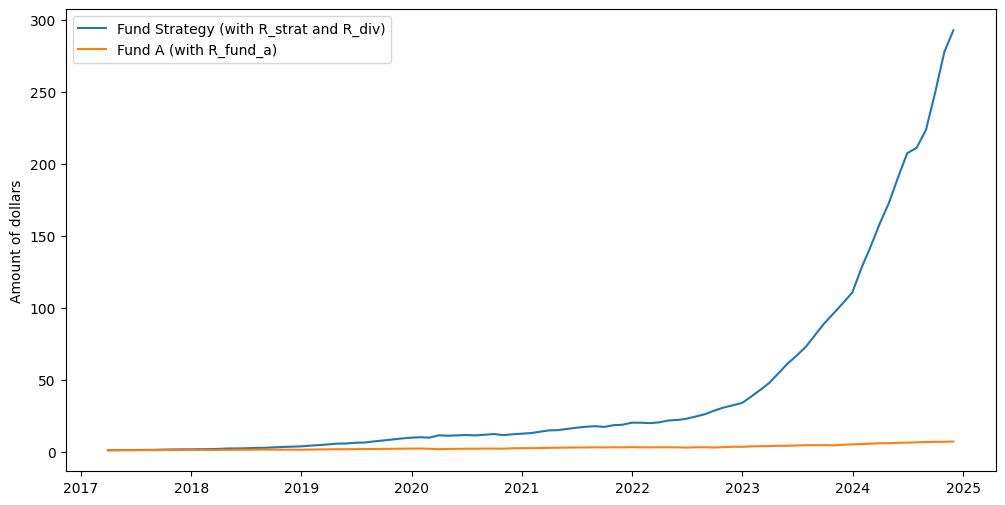

In [75]:
plt.figure(figsize=(12, 6))

common = r_fund_a.index.intersection(fund_strategy.index)
aligned_r_fund_a = r_fund_a.loc[common]

cumulative_a = (1 + aligned_r_fund_a).cumprod()
cumulative_strat = (1 + fund_strategy).cumprod()


plt.plot(fund_strategy.index, cumulative_strat, label='Fund Strategy (with R_strat and R_div)')
plt.plot(fund_strategy.index, cumulative_a, label='Fund A (with R_fund_a)')

plt.ylabel('Amount of dollars')
plt.legend()


plt.show()


## 9 -  Performance and risk analysis for the Fund strategy

In [76]:
fama_french = pd.read_csv('data/FamaFrench.csv')
fama_french['date'] = pd.to_datetime(fama_french['date'].astype(str), format='%Y%m').dt.to_period('M').dt.to_timestamp('M')
fama_french = fama_french.set_index('date')

#Decimal
fama_french = fama_french/100
fama_french = fama_french.drop(columns='RF')

In [77]:
rf = Rf.loc[fund_strategy.index]
excess_fund = fund_strategy - rf['rf']

fama_french = fama_french.loc[excess_fund.index]

In [78]:
y = excess_fund 
X = fama_french
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [79]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.676
Date:                Thu, 12 Jun 2025   Prob (F-statistic):              0.149
Time:                        18:59:20   Log-Likelihood:                 164.17
No. Observations:                  93   AIC:                            -316.3
Df Residuals:                      87   BIC:                            -301.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0611      0.005     13.072      0.0

The strategy delivers a statistically significant positive alpha (≈6.1% per month), yet shows no meaningful loadings on the market or Fama–French factors (all betas are indistinguishable from zero). With an R² under 0.1, these common risk factors do a poor job of explaining its returns.
In other words, rather than being driven by the market or SMB/HML/RMW/CMA, this return series behaves like a near zero-beta, positive-alpha “anomaly” relative to the Fama–French framework.

### 9.b

- EMH predicts that once you adjust for all known risk factors, no strategy should earn a **persistent, statistically significant** α.  
- Our strategy’s **large, robust α** (~6 % p.m.) implies either:  
  1. A genuine market inefficiency (an “anomaly” we’re harvesting), or  
  2. Exposure to **omitted** risk premia not captured by the standard five-factor model.

- **CAPM** says a zero-beta asset should earn the risk-free rate.  
- Here, our strategy has **nearly zero market β** yet delivers **far above** the T-bill return.  
- This directly **contradicts CAPM**—it behaves like a zero-beta, positive-alpha “free lunch.”

- **APT** allows multiple factors, but they must explain your returns.  
- The Fama–French five factors only explain **~9 %** of the variation (R² ≈ 0.09).  
- The remaining return is a **large unexplained residual** (α).  
- Unless we identify additional, economically justified factors, the performance remains **inconsistent with a standard APT**.